In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional
from keras.utils.np_utils import to_categorical
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
import joblib

import time
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
def StringToBytes(data):
    sum = 0
    arrbytes = bytes(data, 'utf-8')
    for i in arrbytes:
        sum = sum + i
    return(sum)

In [3]:
data_normal_1 = pd.read_csv('dataset/timeseries/udp_dataset_timeseries_normal_1.csv')
data_normal_2 = pd.read_csv('dataset/timeseries/udp_dataset_timeseries_normal_2.csv')
data_normal_3 = pd.read_csv('dataset/timeseries/udp_dataset_timeseries_normal_3.csv')
data_normal_4 = pd.read_csv('dataset/timeseries/udp_dataset_timeseries_normal_4.csv')

data_normal_5 = pd.read_csv('dataset/timeseries/old/dataset_udp_timeseries_normal_1.csv')
data_normal_6 = pd.read_csv('dataset/timeseries/old/dataset_udp_timeseries_normal_2.csv')
data_normal_7 = pd.read_csv('dataset/timeseries/old/dataset_udp_timeseries_normal_3.csv')

data_attack_1 = pd.read_csv('dataset/timeseries/udp_dataset_timeseries_attack_1.csv')
data_attack_2 = pd.read_csv('dataset/timeseries/udp_dataset_timeseries_attack_2.csv')
data_attack_3 = pd.read_csv('dataset/timeseries/udp_dataset_timeseries_attack_3.csv')

data_attack_4 = pd.read_csv('dataset/timeseries/old/dataset_udp_timeseries_attack_1.csv')
data_attack_5 = pd.read_csv('dataset/timeseries/old/dataset_udp_timeseries_attack_2.csv')

In [4]:
data_normal_1.columns = ['port_src', 'len', 'chksum', 'payload_len', 'label']
data_normal_2.columns = ['port_src', 'len', 'chksum', 'payload_len', 'label']
data_normal_3.columns = ['port_src', 'len', 'chksum', 'payload_len', 'label']
data_normal_4.columns = ['port_src', 'len', 'chksum', 'payload_len', 'label']

data_normal_5.columns = ['timestamp', 'port_src', 'port_dest',
       'len', 'chksum', 'payload_len', 'label']
data_normal_6.columns = ['timestamp', 'port_src', 'port_dest',
       'len', 'chksum', 'payload_len', 'label']
data_normal_7.columns = ['timestamp', 'port_src', 'port_dest',
       'len', 'chksum', 'payload_len', 'label']

data_attack_1.columns = ['port_src', 'len', 'chksum', 'payload_len', 'label']
data_attack_2.columns = ['port_src', 'len', 'chksum', 'payload_len', 'label']
data_attack_3.columns = ['port_src', 'len', 'chksum', 'payload_len', 'label']

data_attack_4.columns = ['timestamp', 'port_src', 'port_dest',
       'len', 'chksum', 'payload_len', 'label']
data_attack_5.columns = ['timestamp', 'port_src', 'port_dest',
       'len', 'chksum', 'payload_len', 'label']

In [5]:
data_normal_5 = data_normal_5.drop(['timestamp', 'port_dest'],axis=1)
data_normal_6 = data_normal_6.drop(['timestamp', 'port_dest'],axis=1)
data_normal_7 = data_normal_7.drop(['timestamp', 'port_dest'],axis=1)

data_attack_4 = data_attack_4.drop(['timestamp', 'port_dest'],axis=1)
data_attack_5 = data_attack_5.drop(['timestamp', 'port_dest'],axis=1)

In [6]:
features = ['port_src', 'len', 'chksum', 'payload_len']

In [7]:
X_normal_1 = data_normal_1[features].values
X_normal_2 = data_normal_2[features].values
X_normal_3 = data_normal_3[features].values
X_normal_4 = data_normal_4[features].values
X_normal_5 = data_normal_5[features].values
X_normal_6 = data_normal_6[features].values
X_normal_7 = data_normal_7[features].values

X_attack_1 = data_attack_1[features].values
X_attack_2 = data_attack_2[features].values
X_attack_3 = data_attack_3[features].values
X_attack_4 = data_attack_4[features].values
X_attack_5 = data_attack_5[features].values

Y_normal_1 = data_normal_1['label']
Y_normal_2 = data_normal_2['label']
Y_normal_3 = data_normal_3['label']
Y_normal_4 = data_normal_4['label']
Y_normal_5 = data_normal_5['label']
Y_normal_6 = data_normal_6['label']
Y_normal_7 = data_normal_7['label']

Y_attack_1 = data_attack_1['label']
Y_attack_2 = data_attack_2['label']
Y_attack_3 = data_attack_3['label']
Y_attack_4 = data_attack_4['label']
Y_attack_5 = data_attack_5['label']

X=np.concatenate((X_normal_1,X_normal_2,X_normal_3,X_normal_4,X_normal_5,X_normal_6,X_normal_7,X_attack_1,X_attack_2,X_attack_3,X_attack_4,X_attack_5))
Y=np.concatenate((Y_normal_1,Y_normal_2,Y_normal_3,Y_normal_4,Y_normal_5,Y_normal_6,Y_normal_7,Y_attack_1,Y_attack_2,Y_attack_3,Y_attack_4,Y_attack_5))

In [8]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

In [9]:
print(np.shape(X))
print(np.shape(Y))

(145308, 4)
(145308,)


In [10]:
features = len(X[0])
samples = X.shape[0]
train_len = 200
input_len = samples - train_len
I = np.zeros((samples - train_len, train_len, features))

In [11]:
for i in range(input_len):
    temp = np.zeros((train_len, features))
    for j in range(i, i + train_len - 1):
        temp[j-i] = X[j]
    I[i] = temp

In [12]:
print(I.shape)

(145108, 200, 4)


In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(I, Y[200:], test_size = 0.2, stratify=Y[200:], random_state = 0)

In [14]:
def create_baseline():
    model = Sequential()
    model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [15]:
model = create_baseline()

In [16]:
checkpoint = ModelCheckpoint("LSTMmodel.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [17]:
history = model.fit(X_train, Y_train, epochs = 30,validation_split=0.2, verbose = 1, callbacks=[checkpoint,early])

Epoch 1/30
2902/2903 [============================>.] - ETA: 0s - loss: 0.3917 - accuracy: 0.8791
Epoch 00001: val_loss improved from inf to 0.34969, saving model to LSTMmodel.h5
2903/2903 [==============================] - 80s 26ms/step - loss: 0.3917 - accuracy: 0.8791 - val_loss: 0.3497 - val_accuracy: 0.8785
Epoch 2/30
2901/2903 [============================>.] - ETA: 0s - loss: 0.2065 - accuracy: 0.9472
Epoch 00002: val_loss improved from 0.34969 to 0.11085, saving model to LSTMmodel.h5
2903/2903 [==============================] - 74s 26ms/step - loss: 0.2065 - accuracy: 0.9472 - val_loss: 0.1109 - val_accuracy: 0.9885
Epoch 3/30
2902/2903 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.9241
Epoch 00003: val_loss did not improve from 0.11085
2903/2903 [==============================] - 74s 26ms/step - loss: 0.2693 - accuracy: 0.9241 - val_loss: 0.1674 - val_accuracy: 0.9768
Epoch 4/30
2902/2903 [============================>.] - ETA: 0s - loss: 0.2072 - acc

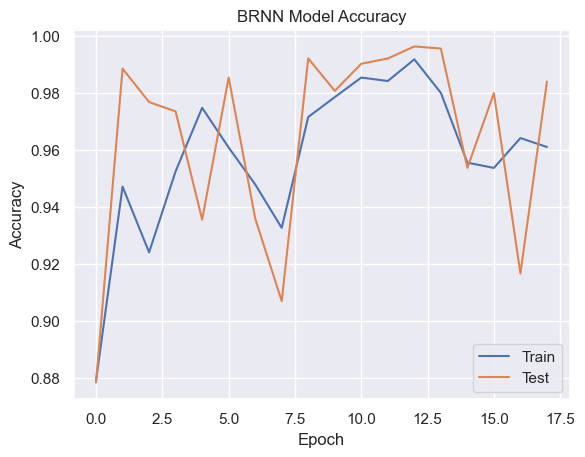

In [18]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('BRNN 200 Model Accuracy.png')
plt.show()

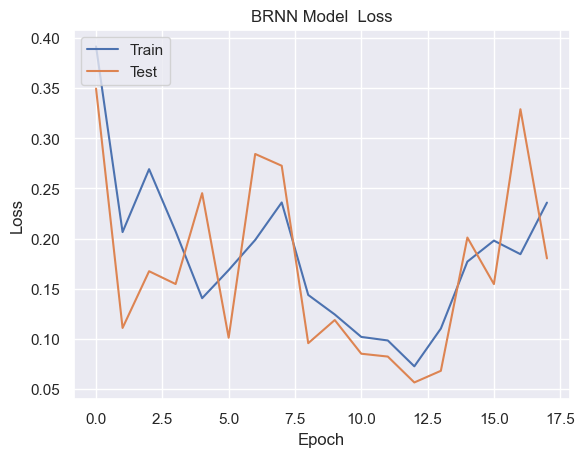

In [19]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('BRNN 200 Model Loss.png')
plt.show()

In [20]:
predict = model.predict(X_test, verbose=1)

907/907 [==============================] - 10s 11ms/step


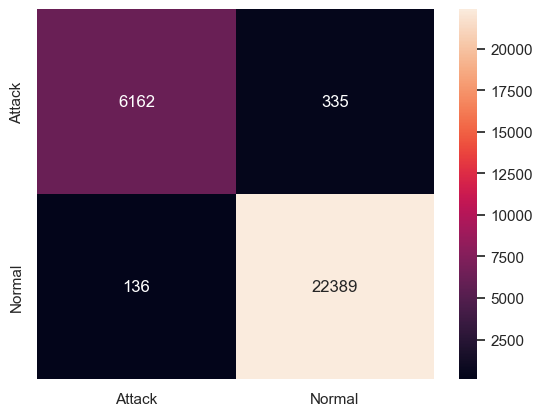

In [21]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = Y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

In [22]:
figure = ax.get_figure()
figure.savefig('confusion_matrix_BRNN_200.png', dpi=400)

In [23]:
# model.save('brnn_model_200_step.h5')
joblib.dump(scalar, 'scaler_200.save')

['scaler_200.save']

In [24]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 98.38%


In [25]:
print(classification_report(Y_testn,predictn))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      6298
           1       0.99      0.99      0.99     22724

    accuracy                           0.98     29022
   macro avg       0.97      0.98      0.98     29022
weighted avg       0.98      0.98      0.98     29022



In [26]:
lr_auc = roc_auc_score(Y_testn, predictn)
print('SVM: ROC AUC=%.3f' % (lr_auc))

SVM: ROC AUC=0.982


In [27]:
time_start = time.perf_counter()
predict = model.predict(I[:200], verbose=1)
print(f"Time elapse for prediction : {time.perf_counter() - time_start}")
print(predict)

7/7 [==============================] - 0s 11ms/step
Time elapse for prediction : 0.10593300000005001
[[0.07788831]
 [0.07706735]
 [0.07699622]
 [0.0769751 ]
 [0.0763231 ]
 [0.07594107]
 [0.07574145]
 [0.07635874]
 [0.07641456]
 [0.07549353]
 [0.07479765]
 [0.07452157]
 [0.0747706 ]
 [0.07472705]
 [0.07473147]
 [0.07429252]
 [0.0744674 ]
 [0.07524336]
 [0.07463369]
 [0.07485508]
 [0.07417241]
 [0.07468915]
 [0.07425831]
 [0.07408648]
 [0.07456594]
 [0.07426605]
 [0.07439741]
 [0.07511134]
 [0.07454992]
 [0.07428937]
 [0.07459019]
 [0.07408241]
 [0.07391033]
 [0.07368618]
 [0.07348034]
 [0.07330145]
 [0.07353959]
 [0.07306089]
 [0.07304922]
 [0.0735905 ]
 [0.07316402]
 [0.07324702]
 [0.0730902 ]
 [0.07296006]
 [0.07305848]
 [0.07358299]
 [0.07311499]
 [0.07313713]
 [0.07379573]
 [0.07360312]
 [0.0737612 ]
 [0.07347531]
 [0.07289656]
 [0.07378707]
 [0.07409737]
 [0.07322506]
 [0.0727336 ]
 [0.07369038]
 [0.07307327]
 [0.07262879]
 [0.07309718]
 [0.07266502]
 [0.07282427]
 [0.07250063]
 [0